In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller

#### IMPORT DATA AND ESTABLISH START AND END DATES ####

In [2]:
# Create the foundational dataset
df = pd.read_csv('cpi_fah_eda_dataset.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[(df['date'] >= '2009-01-01') & (df['date'] <= '2025-01-01')] # need to clear out all of the missing data due to lags
df = df.reset_index().set_index('date').drop(columns = 'index')

In [3]:
for col in df.columns:
    print(col)

grocery_sales
cpi_fah
restaurant_sales
oil_prices
ppi_farm_products
ppi_food_mfg
ppi_grocery
wages_retail
grocery_units
covid1
covid2
grocery_sales_diff
cpi_fah_diff
restaurant_sales_diff
oil_prices_diff
ppi_farm_products_diff
ppi_food_mfg_diff
ppi_grocery_diff
wages_retail_diff
grocery_units_diff
grocery_sales_yoy
cpi_fah_yoy
restaurant_sales_yoy
oil_prices_yoy
ppi_farm_products_yoy
ppi_food_mfg_yoy
ppi_grocery_yoy
wages_retail_yoy
grocery_units_yoy
cpi_fah_yoy_lag1
cpi_fah_yoy_lag2
cpi_fah_yoy_lag3
cpi_fah_yoy_lag4
cpi_fah_yoy_lag5
cpi_fah_yoy_lag6
cpi_fah_yoy_lag7
cpi_fah_yoy_lag8
cpi_fah_yoy_lag9
cpi_fah_yoy_lag10
cpi_fah_yoy_lag11
cpi_fah_yoy_lag12
oil_prices_yoy_lag1
oil_prices_yoy_lag2
oil_prices_yoy_lag3
oil_prices_yoy_lag4
oil_prices_yoy_lag5
oil_prices_yoy_lag6
oil_prices_yoy_lag7
oil_prices_yoy_lag8
oil_prices_yoy_lag9
oil_prices_yoy_lag10
oil_prices_yoy_lag11
oil_prices_yoy_lag12
ppi_farm_products_yoy_lag1
ppi_farm_products_yoy_lag2
ppi_farm_products_yoy_lag3
ppi_farm_produ

#### RENAME COLUMNS FOR THE MODEL ####

#### CHECK FOR MISSING VALUES ####

In [4]:
# Nothing kills a regression faster than missing data

# Count total missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Series([], dtype: int64)

#### PPI MFG MODEL VS OIL PRICES ####

In [5]:
# Define independent (X) and dependent (y) variables
X = df[['oil_prices_yoy_lag1']]
y = df['ppi_farm_products_yoy']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
ppi_model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(ppi_model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['ppi_farm_products_yoy_pred'] = ppi_model.fittedvalues
df['ppi_farm_products_yoy_resid'] = ppi_model.resid

                              OLS Regression Results                             
Dep. Variable:     ppi_farm_products_yoy   R-squared:                       0.466
Model:                               OLS   Adj. R-squared:                  0.463
Method:                    Least Squares   F-statistic:                     166.4
Date:                   Sun, 06 Apr 2025   Prob (F-statistic):           8.75e-28
Time:                           17:16:35   Log-Likelihood:                -723.21
No. Observations:                    193   AIC:                             1450.
Df Residuals:                        191   BIC:                             1457.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cons

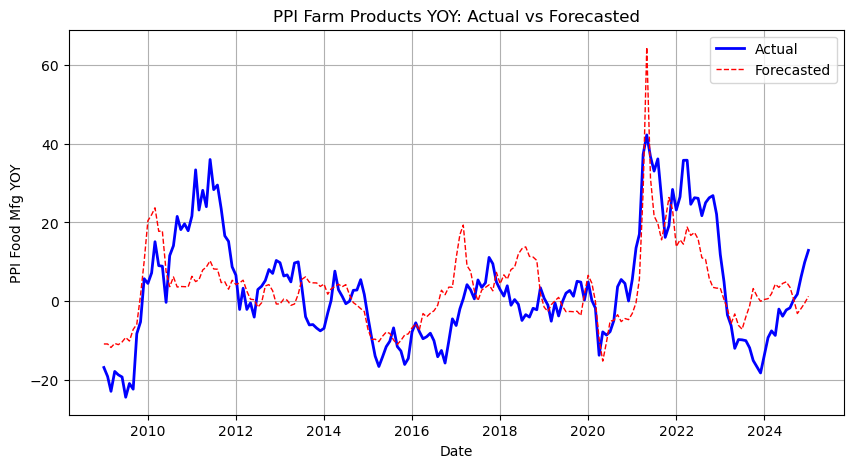

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='ppi_farm_products_yoy', label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df, x=df.index, y='ppi_farm_products_yoy_pred', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('PPI Food Mfg YOY')
plt.title('PPI Farm Products YOY: Actual vs Forecasted')
plt.legend()
plt.grid(True)

plt.show()

#### CPI FAH MODEL VS PPI MEASURES ####

In [7]:
#df = df[(df.index >= '2007-01-01') & (df.index <= '2025-01-01')]

# Define independent (X) and dependent (y) variables
X = df[['ppi_food_mfg_yoy_lag5', 'ppi_grocery_yoy_lag1', 'ppi_farm_products_yoy_lag2', 'grocery_units_yoy', 'oil_prices_yoy_lag6']]
y = df['cpi_fah_yoy']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
cpi_model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(cpi_model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['cpi_fah_yoy_pred'] = cpi_model.fittedvalues
df['cpi_fah_yoy_resid'] = cpi_model.resid

                            OLS Regression Results                            
Dep. Variable:            cpi_fah_yoy   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     222.0
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           1.25e-76
Time:                        17:16:35   Log-Likelihood:                -316.62
No. Observations:                 193   AIC:                             645.2
Df Residuals:                     187   BIC:                             664.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### VISUALS AND DIAGNOSTICS ####

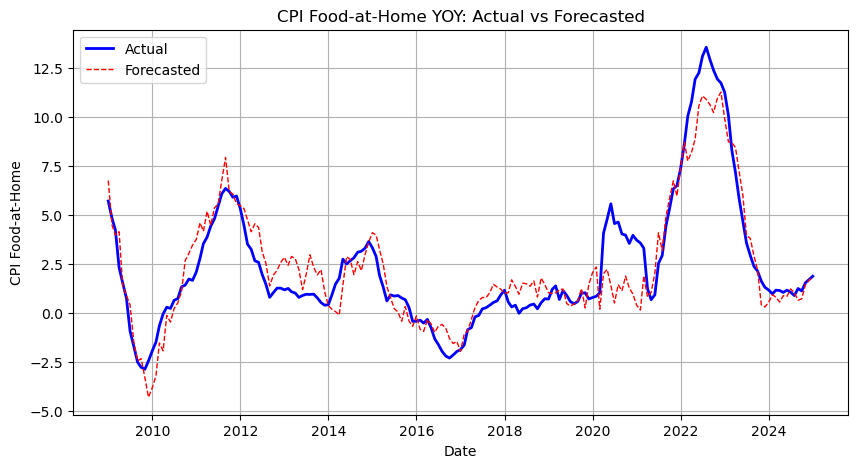

In [8]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='cpi_fah_yoy', label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df, x=df.index, y='cpi_fah_yoy_pred', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('CPI Food-at-Home')
plt.title('CPI Food-at-Home YOY: Actual vs Forecasted')
plt.legend()
plt.grid(True)

plt.show()

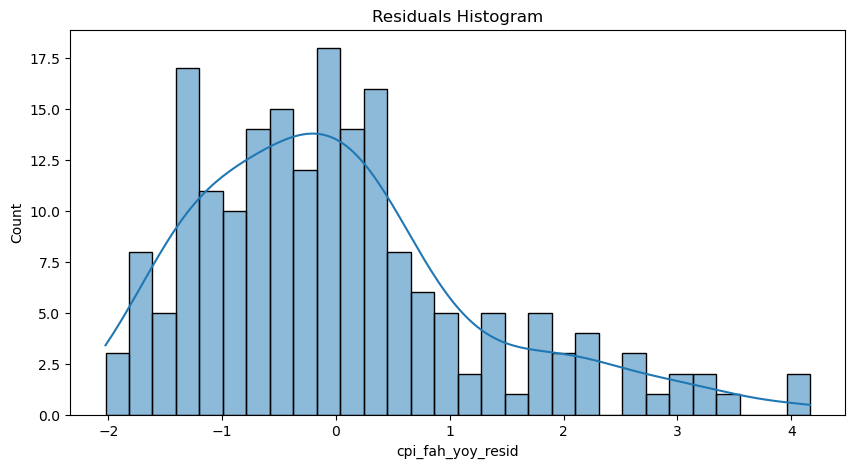

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df["cpi_fah_yoy_resid"], bins=30, kde=True)
plt.title('Residuals Histogram')
plt.show()

<Figure size 1000x500 with 0 Axes>

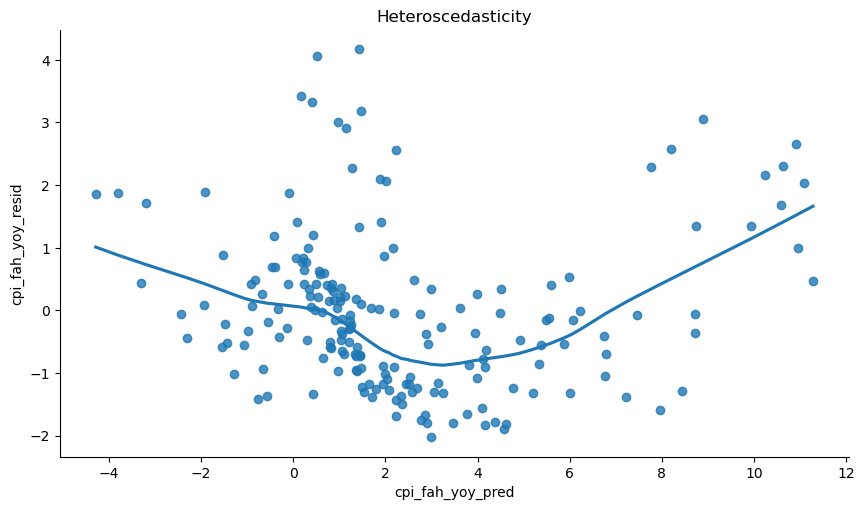

In [10]:
plt.figure(figsize=(10, 5))
sns.lmplot(x="cpi_fah_yoy_pred", y="cpi_fah_yoy_resid", data=df, lowess=True, aspect=1.75, height=5)
plt.title('Heteroscedasticity')
plt.show()

In [11]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

,Feature,VIF
0,const,2.714699
1,ppi_food_mfg_yoy_lag5,2.977993
2,ppi_grocery_yoy_lag1,1.725769
3,ppi_farm_products_yoy_lag2,1.823708
4,grocery_units_yoy,1.370379
5,oil_prices_yoy_lag6,1.762915


#### GET SE MEAN AND CONFIDENCE INTERVALS ####

In [12]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = cpi_model.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store confidence intervals
df['cpi_fah_yoy_se_mean'] = pred_summary['mean_se']  # SE of the mean
df['cpi_fah_yoy_se_lower'] = pred_summary['mean_ci_lower']  # SE of the mean
df['cpi_fah_yoy_se_upper'] = pred_summary['mean_ci_upper']  # SE of the mean
df['lower_bound'] = pred_summary['obs_ci_lower']  # SE of the mean
df['upper_bound'] = pred_summary['obs_ci_upper']  # SE of the mean

# ✅ Compute SE of the estimate (obs_se) using the upper and lower columns 
df['cpi_fah_yoy_se_obs'] = (df['upper_bound'] - df['lower_bound']) / (2 * 1.96)  # 95% CI

# # Show first few rows
df[['cpi_fah_yoy_se_mean', 'cpi_fah_yoy_se_mean', 'cpi_fah_yoy_se_obs', 'cpi_fah_yoy_se_lower', 'cpi_fah_yoy_se_upper', 
    'lower_bound', 'upper_bound']].head()

,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_obs,cpi_fah_yoy_se_lower,cpi_fah_yoy_se_upper,lower_bound,upper_bound
date,,,,,,,
2009-01-01,0.326403,0.326403,1.317759,6.126468,7.414278,4.187565,9.353181
2009-02-01,0.394994,0.394994,1.336643,3.725506,5.283941,1.884902,7.124545
2009-03-01,0.339793,0.339793,1.321183,3.325907,4.666546,1.406707,6.585746
2009-04-01,0.274146,0.274146,1.305641,3.618085,4.699719,1.599847,6.717958
2009-05-01,0.294366,0.294366,1.310093,0.786471,1.947882,-1.200605,3.934958


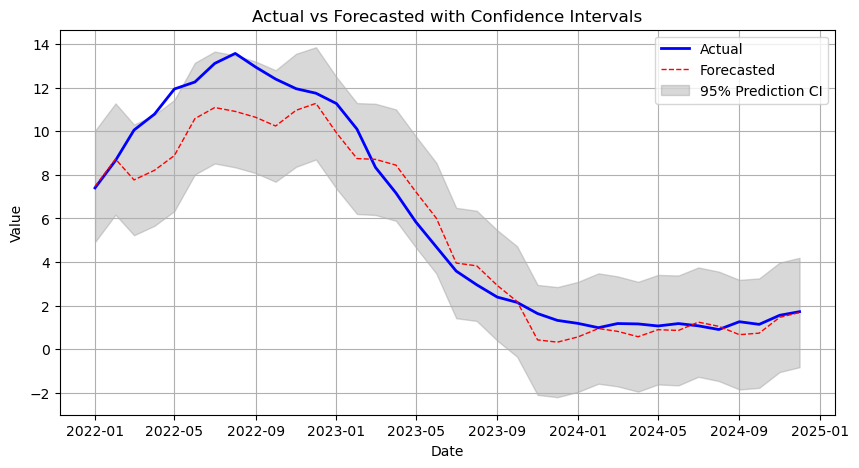

In [13]:
#Define the start and end date for filtering
start_date = '2022-01-01'
end_date = '2024-12-31'

#Filter the DataFrame to only include the desired months
df_subset = df.loc[start_date:end_date]
df_subset

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_subset, x=df_subset.index, y=df_subset['cpi_fah_yoy'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_subset, x=df_subset.index, y='cpi_fah_yoy_pred', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_subset.index, df_subset['lower_bound'], df_subset['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


#### VALIDATE THE MODEL ####

In [14]:
# Make sure the index is datetime and sorted
df_validate = df.sort_index()
df_validate.index = pd.to_datetime(df_validate.index)  # If it's not already datetime

results = []

# Define unique months in the index
all_months = df_validate.index.to_period('M').unique()  # PeriodIndex for monthly grouping

# Define rolling parameters
n_periods = 24  # last 24 months
test_window = 6

for i in range(len(all_months) - n_periods, len(all_months) - test_window + 1):
    test_months = all_months[i:i + test_window]
    train_months = all_months[:i]

    train_df = df_validate[df_validate.index.to_period('M').isin(train_months)]
    test_df = df_validate[df_validate.index.to_period('M').isin(test_months)]
    
    # ✅ Define train and test features and targets
    X_train = train_df[['ppi_food_mfg_yoy_lag5', 'ppi_grocery_yoy_lag1', 'ppi_farm_products_yoy_lag2', 'grocery_units_yoy', 'oil_prices_yoy_lag6']]
    y_train = train_df["cpi_fah_yoy"]

    X_test = test_df[['ppi_food_mfg_yoy_lag5', 'ppi_grocery_yoy_lag1', 'ppi_farm_products_yoy_lag2', 'grocery_units_yoy','oil_prices_yoy_lag6']]
    y_test = test_df["cpi_fah_yoy"]
    
    # ✅ Fit model and predict
    cpi_validate = LinearRegression()
    cpi_validate.fit(X_train, y_train)
    forecast = cpi_validate.predict(X_test)

    mae = mean_absolute_error(y_test, forecast)
    
    results.append({
        'test_start': test_months[0].strftime('%Y-%m'),
        'test_end': test_months[-1].strftime('%Y-%m'),
        'MAE': mae,
        'Actual': y_test.values,
        'Forecast': forecast
    })

# Turn results into a DataFrame
rolling_results_df = pd.DataFrame(results)


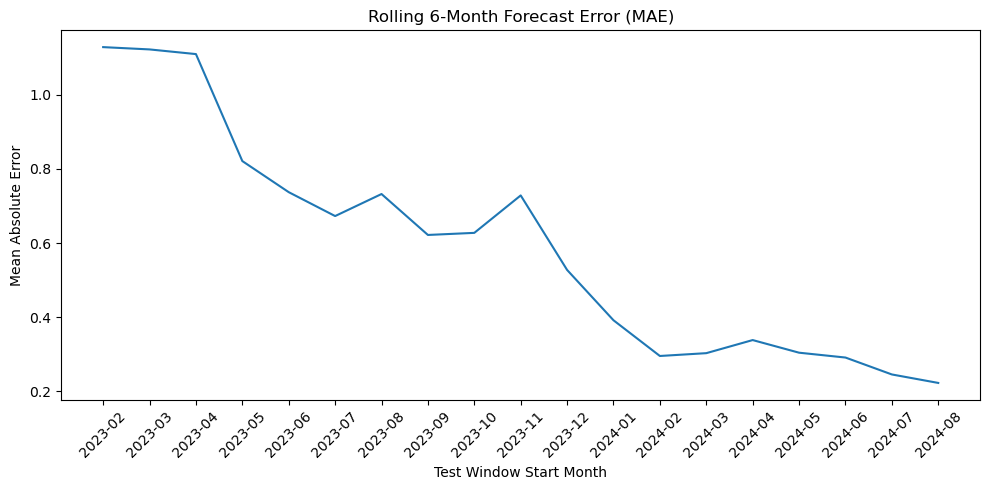

In [15]:
# Drop rows where MAE is NaN
plot_data = rolling_results_df.dropna(subset=['MAE'])

# Now plot
plt.figure(figsize=(10, 5))
plt.plot(plot_data['test_start'], plot_data['MAE'])
plt.xticks(rotation=45)
plt.title('Rolling 6-Month Forecast Error (MAE)')
plt.xlabel('Test Window Start Month')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.show()

#### FORWARD FORECAST - ESTIMATE THE INPUTS AND BUILD THE FILE ####

In [16]:
#Independent forward forecast estimates

ppi_grocery_yoy_dic = {pd.Timestamp('2025-02-01'): 1.8, pd.Timestamp('2025-03-01'): 2.0, pd.Timestamp('2025-04-01'): 2.2, pd.Timestamp('2025-05-01'): 2.4,
                pd.Timestamp('2025-06-01'): 2.6, pd.Timestamp('2025-07-01'): 2.8}

ppi_mfg_yoy_dic = {pd.Timestamp('2025-02-01'): 2.1, pd.Timestamp('2025-03-01'): 3.7, pd.Timestamp('2025-04-01'): 3.3, pd.Timestamp('2025-05-01'): 4.4,
                pd.Timestamp('2025-06-01'): 5.2, pd.Timestamp('2025-07-01'): 5.25}

ppi_farm_products_yoy_dic = {pd.Timestamp('2025-02-01'): -1.7, pd.Timestamp('2025-03-01'): 0.35, pd.Timestamp('2025-04-01'): 1.74, pd.Timestamp('2025-05-01'): 6.1,
                pd.Timestamp('2025-06-01'): 9.86, pd.Timestamp('2025-07-01'): 12.88}

us_grocery_units_yoy_dic = {pd.Timestamp('2025-02-01'): 2.0, pd.Timestamp('2025-03-01'): 1.9, pd.Timestamp('2025-04-01'): 1.8, pd.Timestamp('2025-05-01'): 1.7,
                pd.Timestamp('2025-06-01'): 1.6, pd.Timestamp('2025-07-01'): 1.5}

oil_prices_yoy_dic = {pd.Timestamp('2025-02-01'): -15.9, pd.Timestamp('2025-03-01'): -9.95, pd.Timestamp('2025-04-01'): -2.47, pd.Timestamp('2025-05-01'): 2.14,
                pd.Timestamp('2025-06-01'): -7.39, pd.Timestamp('2025-07-01'): -16.04}

In [17]:
df['cpi_fah_yoy_se_obs']

date
2009-01-01    1.317759
2009-02-01    1.336643
2009-03-01    1.321183
2009-04-01    1.305641
2009-05-01    1.310093
                ...   
2024-09-01    1.283082
2024-10-01    1.282017
2024-11-01    1.281538
2024-12-01    1.280905
2025-01-01    1.280271
Name: cpi_fah_yoy_se_obs, Length: 193, dtype: float64

#### BUILD THE FORWARD FILE AND PREP FOR CONCAT ####

In [18]:
# Define the forward forecast period and build the file

# Build the df based on the date range.  The months become the index
forecast_months = pd.date_range("2025-02-01", "2025-07-01", freq="MS")
forward_df = pd.DataFrame(index=forecast_months)

# Fill in known inputs by defining the previous year values so we can estimate the YOY values for the forecast
# THis loop grabs last years value and then applies the growth rate to calculate the future input value
# date and prev_year are the outputs that are inserted into the formulas below
for date in forecast_months:
    prev_year = date - pd.DateOffset(years=1)  
    
    forward_df.loc[date, "ppi_grocery_yoy_lag1"] = ppi_grocery_yoy_dic[date]
    forward_df.loc[date, "ppi_food_mfg_yoy_lag5"] = ppi_mfg_yoy_dic[date]
    forward_df.loc[date, "ppi_farm_products_yoy_lag2"] = ppi_farm_products_yoy_dic[date]
    forward_df.loc[date, "grocery_units_yoy"] = us_grocery_units_yoy_dic[date]
    forward_df.loc[date, "oil_prices_yoy_lag6"] = oil_prices_yoy_dic[date]

# # Initialize lag variable
# last_known_value = df.loc["2025-01-01", "cpi_fah"]
# forward_df["us_grocery_sales_lag1"] = np.nan
# forward_df.loc[forecast_months[0], "us_grocery_sales_lag1"] = last_known_value

# Add empty columns for forecast and intervals
forward_df["cpi_fah_yoy"] = np.nan
forward_df["cpi_fah_yoy_pred"] = np.nan

# Pull the 6 months of SE values from one year ago
se_obs_values = df['cpi_fah_yoy_se_obs'].iloc[-12:-6].copy()  

# Shift the index forward to 2025
se_obs_values.index = se_obs_values.index + pd.DateOffset(years=1)

# Assign these shifted SE values into forward_df
forward_df.loc[se_obs_values.index, 'cpi_fah_yoy_se_obs'] = se_obs_values

forward_df

,ppi_grocery_yoy_lag1,ppi_food_mfg_yoy_lag5,ppi_farm_products_yoy_lag2,grocery_units_yoy,oil_prices_yoy_lag6,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs
2025-02-01,1.8,2.10,-1.70,2.0,-15.90,NaN,NaN,1.292173
2025-03-01,2.0,3.70,0.35,1.9,-9.95,NaN,NaN,1.288079
2025-04-01,2.2,3.30,1.74,1.8,-2.47,NaN,NaN,1.285846
2025-05-01,2.4,4.40,6.10,1.7,2.14,NaN,NaN,1.282674
2025-06-01,2.6,5.20,9.86,1.6,-7.39,NaN,NaN,1.286674
2025-07-01,2.8,5.25,12.88,1.5,-16.04,NaN,NaN,1.280562


In [19]:
for col in forward_df.columns:
    print(col)

ppi_grocery_yoy_lag1
ppi_food_mfg_yoy_lag5
ppi_farm_products_yoy_lag2
grocery_units_yoy
oil_prices_yoy_lag6
cpi_fah_yoy
cpi_fah_yoy_pred
cpi_fah_yoy_se_obs


#### GET THE COEF FOR THE FORWARD FCST ####

In [20]:
cpi_fah_yoy_coef = {name: value for name, value in cpi_model.params.items()}
cpi_fah_yoy_coef

{'const': 0.3325970080233,
 'ppi_food_mfg_yoy_lag5': 0.2831410494978112,
 'ppi_grocery_yoy_lag1': 0.2715185786178153,
 'ppi_farm_products_yoy_lag2': 0.058987600366010175,
 'grocery_units_yoy': -0.07469841695615537,
 'oil_prices_yoy_lag6': 0.005803492810452457}

In [21]:
const = cpi_fah_yoy_coef['const']
ppi_food_mfg_yoy_lag5 = cpi_fah_yoy_coef['ppi_food_mfg_yoy_lag5']
ppi_grocery_yoy_lag1 = cpi_fah_yoy_coef['ppi_grocery_yoy_lag1']
ppi_farm_products_yoy_lag2 = cpi_fah_yoy_coef['ppi_farm_products_yoy_lag2']
grocery_units_yoy = cpi_fah_yoy_coef['grocery_units_yoy']
oil_prices_yoy_lag6 = cpi_fah_yoy_coef['oil_prices_yoy_lag6']

#### MAKE THE FORWARD FCST ####

In [22]:
# Initialize values before the loop
forecasted_cpi_fah = []
lower_ci = []
upper_ci = []

# Loop through each row in forward_df
for i, row in forward_df.iterrows():
    y_hat = (
        const +
        ppi_food_mfg_yoy_lag5 * row['ppi_food_mfg_yoy_lag5'] +
        ppi_grocery_yoy_lag1 * row["ppi_grocery_yoy_lag1"] +
        ppi_farm_products_yoy_lag2 * row["ppi_farm_products_yoy_lag2"] +
        grocery_units_yoy * row['grocery_units_yoy'] +
        oil_prices_yoy_lag6 * row['oil_prices_yoy_lag6']
    )

    forecasted_cpi_fah.append(round(y_hat, 2))

    # Calculate and store confidence intervals
    lower_ci.append(y_hat - 1.96 * row["cpi_fah_yoy_se_obs"])
    upper_ci.append(y_hat + 1.96 * row["cpi_fah_yoy_se_obs"])

# Assign all lists to the DataFrame
forward_df['cpi_fah_yoy_pred'] = forecasted_cpi_fah
forward_df['lower_bound'] = lower_ci
forward_df['upper_bound'] = upper_ci

#### CONCAT THE FORWARD DF AND DF ####

In [23]:
# Stack the df and forward df
df_subset = df[forward_df.columns]
df_full = pd.concat([df_subset, forward_df], axis=0)
df_full.tail(12)

,ppi_grocery_yoy_lag1,ppi_food_mfg_yoy_lag5,ppi_farm_products_yoy_lag2,grocery_units_yoy,oil_prices_yoy_lag6,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs,lower_bound,upper_bound
2024-08-01,3.138049,0.463688,-3.875880,0.586153,0.541916,0.900476,1.046656,1.281357,-1.464804,3.558116
2024-09-01,0.484107,1.232838,-2.296270,1.031872,10.917592,1.258809,0.663938,1.283082,-1.850903,3.178779
2024-10-01,0.756637,1.291654,-1.744943,1.474888,7.427603,1.136562,0.733763,1.282017,-1.778991,3.246516
2024-11-01,1.678139,2.212094,0.354709,0.580579,11.800193,1.554147,1.460615,1.281538,-1.051200,3.972430
2024-12-01,1.839778,2.805668,1.735200,1.698910,13.550934,1.719773,1.680623,1.280905,-0.829950,4.191196
2025-01-01,2.354873,2.221742,6.102522,1.865908,7.533840,1.884939,1.865371,1.280271,-0.643960,4.374701
2025-02-01,1.800000,2.100000,-1.700000,2.000000,-15.900000,NaN,1.070000,1.292173,-1.458683,3.606634
2025-03-01,2.000000,3.700000,0.350000,1.900000,-9.950000,NaN,1.740000,1.288079,-0.780406,4.268866
2025-04-01,2.200000,3.300000,1.740000,1.800000,-2.470000,NaN,1.820000,1.285846,-0.702109,4.338409
2025-05-01,2.400000,4.400000,6.100000,1.700000,2.140000,NaN,2.480000,1.282674,-0.038723,4.989360


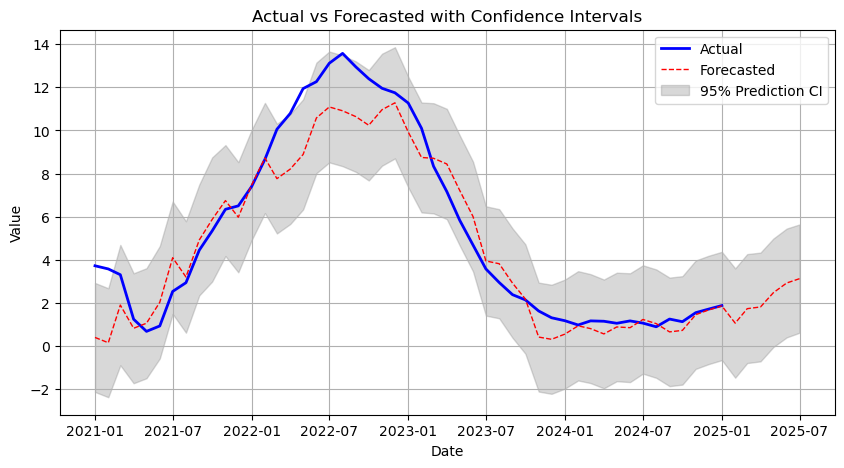

In [24]:
#Define the start and end date for filtering
start_date = '2021-01-01'
end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
df_chart = df_full.loc[start_date:end_date]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['cpi_fah_yoy'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['cpi_fah_yoy_pred'], label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_chart.index, df_chart['lower_bound'], df_chart['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()

In [25]:
df_full.to_csv('cpi_fah_forecast_month.csv')